In [9]:
#Importing necessary libraries
import os, json, pandas as pd
import re, numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import seaborn as sns, matplotlib.pyplot as plt

In [10]:
data_dir = '/Users/aniqakhan/Desktop/Dissertation/NELA-GT2020/nela-gt-2020/newsdata'

all_articles = []
bad_files = []

for root, _, files in os.walk(data_dir):
    for file in files:
        if not file.endswith('.json'):
            continue
        path = os.path.join(root, file)
        try:
            with open(path, 'r', encoding='utf-8', errors='ignore') as f:
                js = json.load(f)
                # Some dumps are list-of-articles; others may be dicts
                if isinstance(js, list):
                    for a in js:
                        a['_source_file'] = file
                        all_articles.append(a)
                elif isinstance(js, dict):
                    arts = js.get('articles') or js.get('data') or []
                    for a in arts:
                        a['_source_file'] = file
                        all_articles.append(a)
        except Exception as e:
            bad_files.append((file, str(e)))

df = pd.DataFrame(all_articles)
print(f"Loaded {len(df):,} articles from {len(all_articles)>0 and len(set([a['_source_file'] for a in all_articles]))} files.")
if bad_files:
    print("Skipped files:", bad_files[:5], "…")

labels_df = pd.read_csv('/Users/aniqakhan/Desktop/Dissertation/NELA-GT2020/labels.csv')

Loaded 1,779,127 articles from 519 files.


In [11]:
#Introducing the huggingface MBFC dataset 
mbfc_df = pd.read_csv("hf://datasets/sergioburdisso/news_media_bias_and_factuality/data.csv")

In [12]:
#Loading all the dataframes
_nela_df  = globals().get('nela_df',  globals().get('df'))
_labels   = globals().get('labels_df', globals().get('labels'))
_mbfc_df  = globals().get('mbfc_df',  globals().get('df_mbfc'))

assert _nela_df is not None,  "NELA articles df not found (expected nela_df or df)."
assert _labels is not None,   "NELA labels df not found (expected labels_df or labels)."
assert _mbfc_df is not None,  "MBFC HF df not found (expected mbfc_df or df_mbfc)."

nela = _nela_df.copy()
labels_df = _labels.copy()
mbfc = _mbfc_df.copy()

if 'source' not in nela.columns: # Ensuring NELA has 'source'
    for alt in ['domain', 'site', 'outlet', 'publisher']:
        if alt in nela.columns:
            nela = nela.rename(columns={alt: 'source'})
            break
assert 'source' in nela.columns, "No 'source' column in NELA articles."

# Ensure labels_df has ('source','label') where label is numeric 0/1/2
if 'label' not in labels_df.columns:
    for alt in ['bias', 'mbfc_bias', 'nela_label']:
        if alt in labels_df.columns:
            labels_df = labels_df.rename(columns={alt: 'label'})
            break
assert 'label' in labels_df.columns and 'source' in labels_df.columns, \
    "labels_df must include 'source' and 'label' (0/1/2)."

if 'source' not in mbfc.columns: # Doing same for MBFC
    for alt in ['domain', 'site', 'news_source']:
        if alt in mbfc.columns:
            mbfc = mbfc.rename(columns={alt: 'source'})
            break
assert 'source' in mbfc.columns, "MBFC df must include a 'source' column."

bias_col_detect = None
for c in ['bias_label','bias','label','mbfc_bias']:
    if c in mbfc.columns:
        bias_col_detect = c
        break
assert bias_col_detect is not None, "Could not find a bias label column in MBFC df."

In [13]:
#Cleaning part
MULTIPART_TLDS = {
    "co.uk","ac.uk","gov.uk","nhs.uk","sch.uk","ltd.uk","plc.uk",
    "com.au","net.au","org.au","edu.au","gov.au",
    "co.nz","org.nz","govt.nz",
    "co.in","org.in","net.in","ac.in","gov.in",
    "co.jp","co.kr","com.sg","com.my","com.br","com.tr"
}

def clean_source(raw):
    if pd.isna(raw):
        return np.nan
    s = str(raw).strip().lower()
    s = re.sub(r'^https?://', '', s)
    s = re.sub(r'^www\.', '', s)
    s = s.split('/')[0]  # drop path/query
    # handle multi-part TLDs first
    for tld in MULTIPART_TLDS:
        if s.endswith('.' + tld):
            s = s[:-(len(tld) + 1)]
            break
    else:
        # single-part TLD
        s = re.sub(r'\.[a-z]{2,}$', '', s)
    return s

nela['source_clean']      = nela['source'].apply(clean_source)
labels_df['source_clean'] = labels_df['source'].apply(clean_source)
mbfc['source_clean']      = mbfc['source'].apply(clean_source)

#Merging the datasets together
merged = nela.merge(labels_df[['source_clean','label']], on='source_clean', how='left', suffixes=('','_nela'))
print("After NELA-labels merge — labeled:", merged['label'].notna().sum(),
      "| unlabeled:", merged['label'].isna().sum())

mbfc_bias = mbfc[['source_clean', bias_col_detect]].rename(columns={bias_col_detect: 'mbfc_bias_text'})
mbfc_bias['mbfc_bias_text'] = mbfc_bias['mbfc_bias_text'].astype(str).str.strip().str.upper()

merged = merged.merge(mbfc_bias, on='source_clean', how='left')

After NELA-labels merge — labeled: 1290431 | unlabeled: 490364


In [14]:
#Doing a fuzzy match to try and match as many headlines as possible
try:
    from rapidfuzz import process, fuzz
    need_fuzzy = merged['label'].isna() & merged['mbfc_bias_text'].isna()
    unmatched = merged.loc[need_fuzzy, 'source_clean'].dropna().unique()

    mbfc_sources = mbfc['source_clean'].dropna().unique()
    mbfc_lookup  = dict(zip(mbfc['source_clean'], mbfc_bias.set_index('source_clean')['mbfc_bias_text']))

    fuzzy_map = {}
    for src in unmatched:
        match = process.extractOne(src, mbfc_sources, scorer=fuzz.partial_ratio)
        if match:
            cand, score, _ = match
            if score >= 90:
                fuzzy_map[src] = mbfc_lookup.get(cand)

    merged['mbfc_bias_text_fuzzy'] = merged['source_clean'].map(fuzzy_map)
    print("Fuzzy-labeled sources:", len(fuzzy_map))
except Exception as e:
    print("[Note] Skipping fuzzy match (rapidfuzz not available or error:", e, ")")
    merged['mbfc_bias_text_fuzzy'] = np.nan

#Merge hit-rate check 
merge_hit = merged['label'].notna() | merged['mbfc_bias_text'].notna() | merged['mbfc_bias_text_fuzzy'].notna()
print(f"Merge hit-rate (any label present): {merge_hit.mean():.2%}")

#Building the labels
nela_num_to_3cat = {
    0: 'LEFT', 1: 'CENTRE', 2: 'RIGHT',
    0.0: 'LEFT', 1.0: 'CENTRE', 2.0: 'RIGHT',
    '0': 'LEFT','1': 'CENTRE','2': 'RIGHT',
    '0.0':'LEFT','1.0':'CENTRE','2.0':'RIGHT'
}

CENTRE_BUCKETS = {
    'CENTER','CENTRE','LEAST_BIASED','LEAST-BIASED','LEAST BIASED',
    'PRO_SCIENCE','PRO-SCIENCE','PRO SCIENCE','NEUTRAL','FACTUAL'
}
LEFT_BUCKETS  = {'LEFT','LEFT-CENTER','LEFT_CENTER','LEFT CENTER'}
RIGHT_BUCKETS = {'RIGHT','RIGHT-CENTER','RIGHT_CENTER','RIGHT CENTER'}

def map_mbfc_text_to_3cat(s):
    if pd.isna(s): return np.nan
    s = str(s).strip().upper()
    if s in LEFT_BUCKETS:   return 'LEFT'
    if s in RIGHT_BUCKETS:  return 'RIGHT'
    if s in CENTRE_BUCKETS: return 'CENTRE'
    # Drop questionable/satire/conspiracy/unknown/etc.
    return np.nan

def choose_label(row):
    # 1) NELA numeric first
    lab = row['label']
    if pd.notna(lab):
        mapped = nela_num_to_3cat.get(lab, nela_num_to_3cat.get(str(lab)))
        if mapped is not None:
            return mapped
    # 2) MBFC exact
    mapped = map_mbfc_text_to_3cat(row.get('mbfc_bias_text'))
    if pd.notna(mapped):
        return mapped
    # 3) MBFC fuzzy
    mapped = map_mbfc_text_to_3cat(row.get('mbfc_bias_text_fuzzy'))
    if pd.notna(mapped):
        return mapped
    return np.nan

merged['polarisation_class'] = merged.apply(choose_label, axis=1)

print("\nClass balance BEFORE dropna():")
print(merged['polarisation_class'].value_counts(dropna=False))

#Keep only labeled rows
labeled_df = merged.dropna(subset=['polarisation_class']).copy()
labeled_df.reset_index(drop=True, inplace=True)
print("\nClass balance (final):")
print(labeled_df['polarisation_class'].value_counts())
print(f"Labeled rows kept: {len(labeled_df):,} / {len(merged):,}")



[Note] Skipping fuzzy match (rapidfuzz not available or error: No module named 'rapidfuzz' )
Merge hit-rate (any label present): 82.13%

Class balance BEFORE dropna():
polarisation_class
RIGHT     621522
LEFT      616361
NaN       328842
CENTRE    273678
Name: count, dtype: int64

Class balance (final):
polarisation_class
RIGHT     621522
LEFT      616361
CENTRE    273678
Name: count, dtype: int64
Labeled rows kept: 1,511,561 / 1,840,403


In [15]:
#Text columns
text_cols  = [c for c in ['content','text','article_text','body'] if c in labeled_df.columns]
title_cols = [c for c in ['title','headline'] if c in labeled_df.columns]

if text_cols:
    labeled_df['__text__'] = labeled_df[text_cols[0]].astype(str)
else:
    if title_cols:
        labeled_df['__text__'] = labeled_df[title_cols[0]].astype(str)
    else:
        raise ValueError("No text columns found (looked for content/text/article_text/body/title/headline).")

if text_cols and title_cols:
    labeled_df['__text__'] = (labeled_df[title_cols[0]].astype(str) + " " + labeled_df[text_cols[0]].astype(str))

labeled_df['__text__'] = labeled_df['__text__'].fillna("").str.strip()

#filtering for speed
MIN_CHARS = 40    # set to None to disable
SAMPLE_N  = None  # e.g., 200_000 to cap size

if MIN_CHARS is not None:
    labeled_df = labeled_df[labeled_df['__text__'].str.len() >= MIN_CHARS].copy()
    print("Rows with usable (≥{} chars) text: {}".format(MIN_CHARS, len(labeled_df)))
else:
    print("Rows with usable text:", len(labeled_df))

if SAMPLE_N is not None and len(labeled_df) > SAMPLE_N:
    labeled_df = shuffle(labeled_df, random_state=42).iloc[:SAMPLE_N].copy()
    print(f"Sampled to {SAMPLE_N:,} rows for speed.")



Rows with usable (≥40 chars) text: 1505320


In [16]:
#Train/test
USE_GROUP_SPLIT = True

if USE_GROUP_SPLIT:
    from sklearn.model_selection import GroupShuffleSplit
    groups = labeled_df['source_clean'].fillna('unknown_source')
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, test_idx = next(gss.split(labeled_df['__text__'], labeled_df['polarisation_class'], groups=groups))
    X_train = labeled_df.iloc[train_idx]['__text__']
    y_train = labeled_df.iloc[train_idx]['polarisation_class']
    X_test  = labeled_df.iloc[test_idx]['__text__']
    y_test  = labeled_df.iloc[test_idx]['polarisation_class']
    print(f"Grouped split by source → train sources: {groups.iloc[train_idx].nunique()}, test sources: {groups.iloc[test_idx].nunique()}")
else:
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        labeled_df['__text__'], labeled_df['polarisation_class'],
        test_size=0.2, random_state=42, stratify=labeled_df['polarisation_class']
    )

#SVM pipeline
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=200_000,
        ngram_range=(1,2),
        min_df=5,
        max_df=0.9,
        sublinear_tf=True,
        lowercase=True,
        stop_words="english"
    )),
    ("clf", LinearSVC(C=1.0, class_weight="balanced", random_state=42))
])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')

print(f"\nAccuracy: {acc:.3f} | Macro-F1: {macro_f1:.3f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=3))
print("Confusion Matrix [LEFT, CENTRE, RIGHT]:")
print(confusion_matrix(y_test, y_pred, labels=['LEFT','CENTRE','RIGHT']))

Grouped split by source → train sources: 290, test sources: 73

Accuracy: 0.450 | Macro-F1: 0.429

Classification Report:
              precision    recall  f1-score   support

      CENTRE      0.379     0.500     0.431     51908
        LEFT      0.572     0.577     0.574    163509
       RIGHT      0.307     0.262     0.283    124189

    accuracy                          0.450    339606
   macro avg      0.419     0.446     0.429    339606
weighted avg      0.445     0.450     0.446    339606

Confusion Matrix [LEFT, CENTRE, RIGHT]:
[[94317 13066 56126]
 [ 8458 25967 17483]
 [62167 29465 32557]]


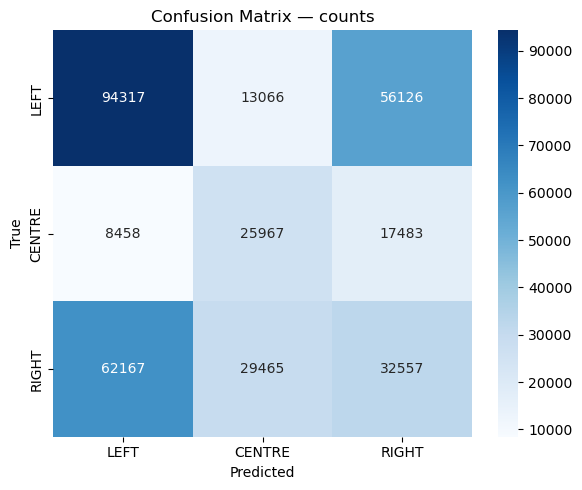

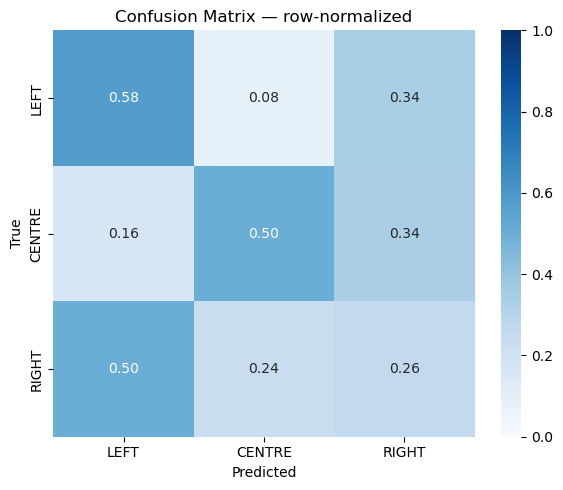

In [17]:
labels = ['LEFT','CENTRE','RIGHT']
cm_df = pd.crosstab(
    pd.Categorical(y_test, categories=labels),
    pd.Categorical(y_pred, categories=labels),
    dropna=False
).fillna(0).astype(int)

plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix — counts')
plt.tight_layout(); plt.show()

# Row-normalized (recall view)
cm_norm = cm_df.div(cm_df.sum(axis=1).replace(0,1), axis=0)
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=labels, yticklabels=labels, vmin=0, vmax=1)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix — row-normalized')
plt.tight_layout(); plt.show()




In [19]:
from pathlib import Path
import joblib
import pandas as pd

# Code for meta model
ROOT = Path.home() / "Desktop" / "Dissertation"
ARTN = ROOT / "nela_artifacts"
ARTN.mkdir(parents=True, exist_ok=True)

# texts 
nela_texts  = labeled_df['__text__'].astype(str).fillna("")

# labels 
nela_labels = labeled_df['polarisation_class'].astype(str).str.upper().str.replace("CENTER","CENTRE", regex=False)

# Normalise labels to LEFT / CENTRE / RIGHT
y = pd.Series(nela_labels)
if y.dtype.kind in "iuf":  # numeric codes 0/1/2 -> map (will be skipped if y is str)
    y = y.map({0:'LEFT', 1:'CENTRE', 2:'RIGHT'})
y = (y.astype(str)
       .str.upper()
       .str.replace("CENTER","CENTRE", regex=False)
       .str.strip())

# Drop any unexpected labels
mask = y.isin({'LEFT','CENTRE','RIGHT'})
if (~mask).any():
    print("Dropping rows with unexpected labels:", y[~mask].value_counts().to_dict())
    nela_texts = pd.Series(nela_texts)[mask]
    y = y[mask]

# Save texts + labels
pd.DataFrame({"text": nela_texts}).to_csv(ARTN / "nela_train_text.csv", index=False)
y.to_csv(ARTN / "nela_train_labels_3.csv", index=False, header=["label"])

# Pick an existing pipeline if present
pipeline = None
for name in ("model_nela", "nela_pipeline", "pipe_nela"):
    if name in globals():
        pipeline = globals()[name]
        print(f"Using existing pipeline: {name}")
        break

# If none, define a default
if pipeline is None:
    from sklearn.pipeline import Pipeline
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.linear_model import LogisticRegression
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words="english")),
        ("clf",   LogisticRegression(max_iter=1000, class_weight="balanced", multi_class="auto"))
    ])
    print("No existing pipeline found; saved a default TF-IDF + LogisticRegression spec.")

joblib.dump(pipeline, ARTN / "nela_pipeline.joblib")
print("Saved:", [p.name for p in ARTN.iterdir()])


No existing pipeline found; saved a default TF-IDF + LogisticRegression spec.
Saved: ['nela_pipeline.joblib', 'nela_train_labels_3.csv', 'nela_train_text.csv']
